In [1]:
import os
import tarfile 
from six.moves import urllib
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [2]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH ):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH) :
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [3]:
# fetch_housing_data()

housing = load_housing_data()


#### First 5 rows of data ####

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### general info about the data, datatypes, row many rows, nullable ####


housing.info()

#### distinct values for an attribute and its count

In [5]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### summary of each attribute and quartile values for the attributes 


In [6]:
# 25% of districts have a housing_median_age lower than 18 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
matplotlib inline

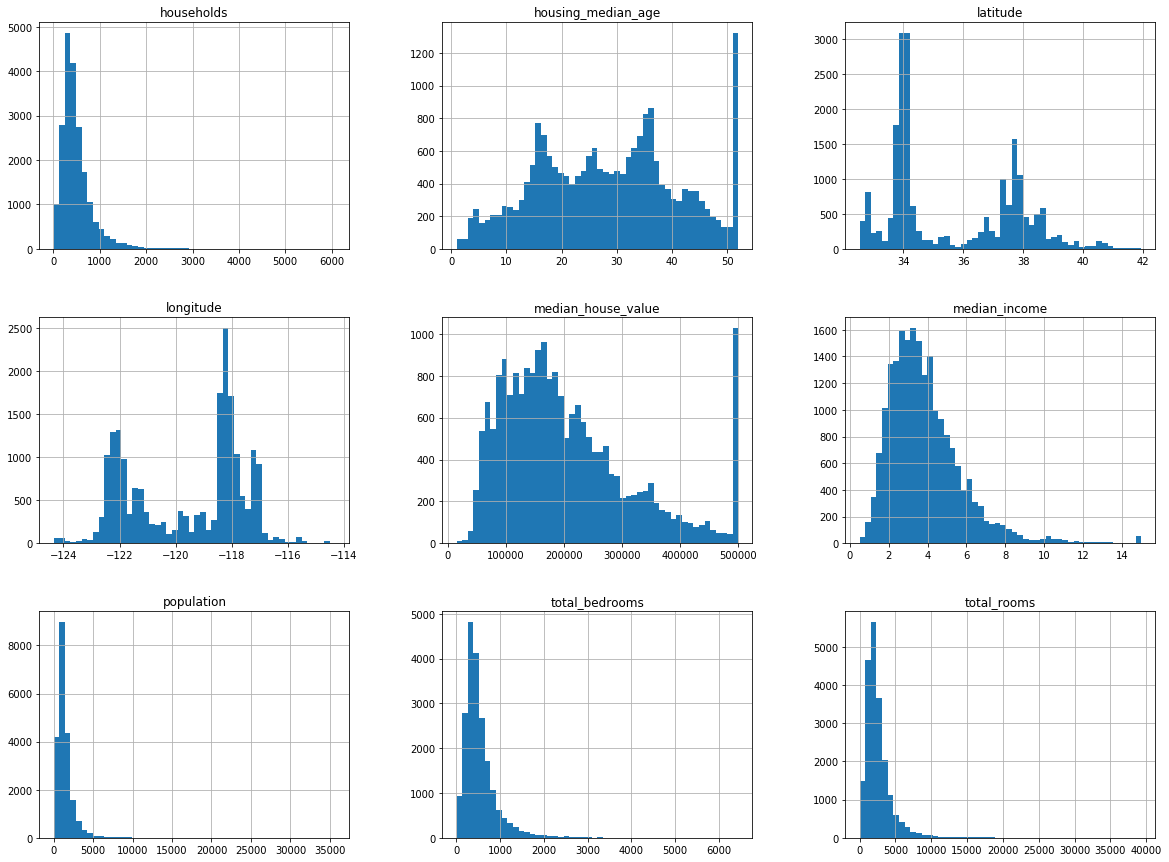

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### lets create our test set ###

could be a random seed generator

```from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)```

but maybe best not to be random, but a sampling that is representative of the data called **Stratified Sampling**
in this a case we want our test set to be a respresentative sampling of income

so split our income datas into 5 distinct categories

In [9]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [11]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

#### Now remove income_cat attribute so the data is back to orignal state ####

In [12]:
for set in (strat_train_set,strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

#### make copy of training set so we can play without harming ####

In [13]:
housing = strat_train_set.copy()

#### geographical plot

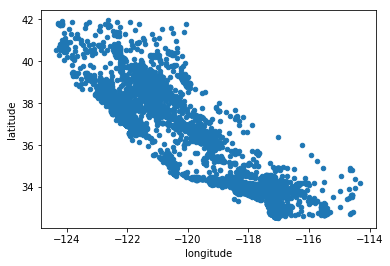

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude")

#### yeah thats california, but makes it real hard to see stuff, so change the alpha


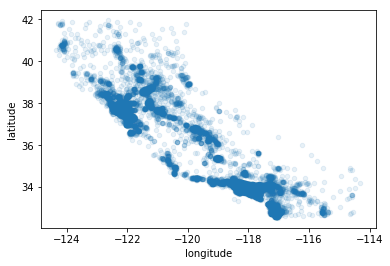

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

#### graph other attributes, circle size = poplulation and color = pricing. use a predefined color map, cmap, called jet

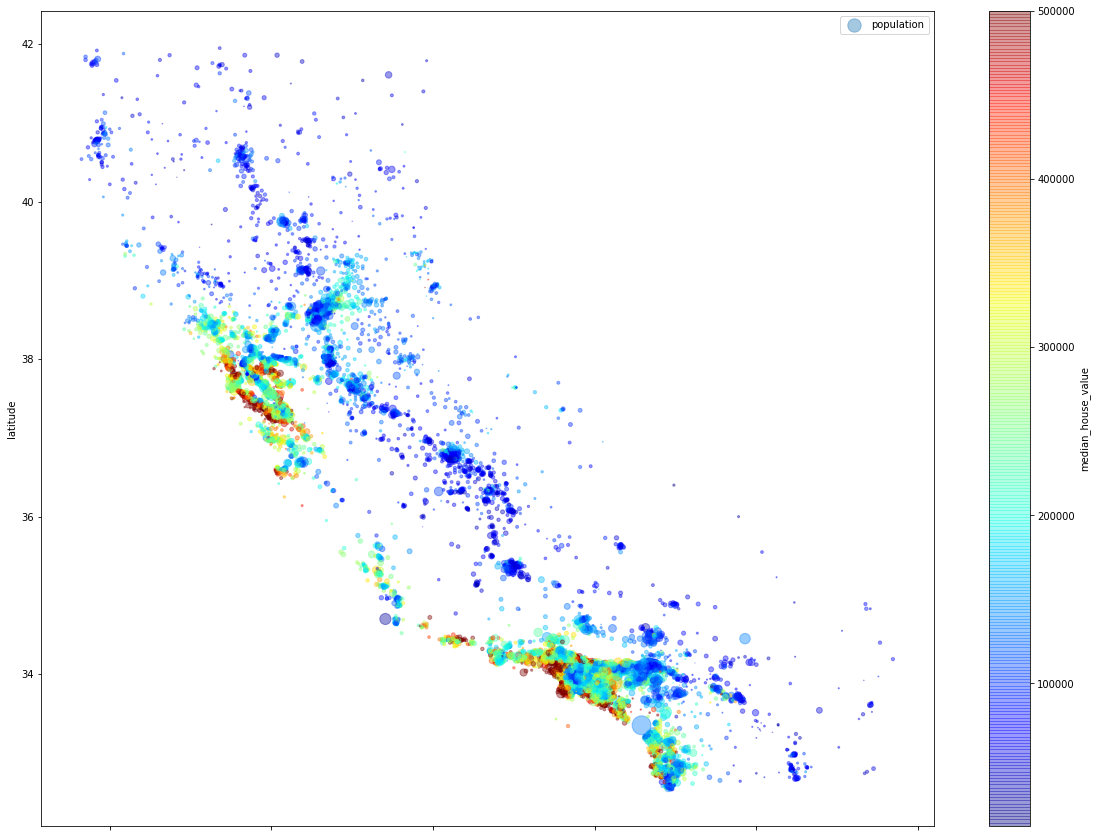

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,15),)
plt.legend()

## looking for correlations
since the dataset is not too large, you can easily compute the standard correlation coefficient between (Pearson's r) between every pair of attributes using the corr() method

In [17]:
corr_matrix = housing.corr()

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

another way to check for correlation between attributes is to use Panda's scatter matrix function, which plotsm every numerical attribute again every other numiercal attribute. since we have 11 attributes, we would get 11^2=121 plots which are too many.  here's a few

/Users/rmai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11991f0f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11971e0b8>]], dtype=object)

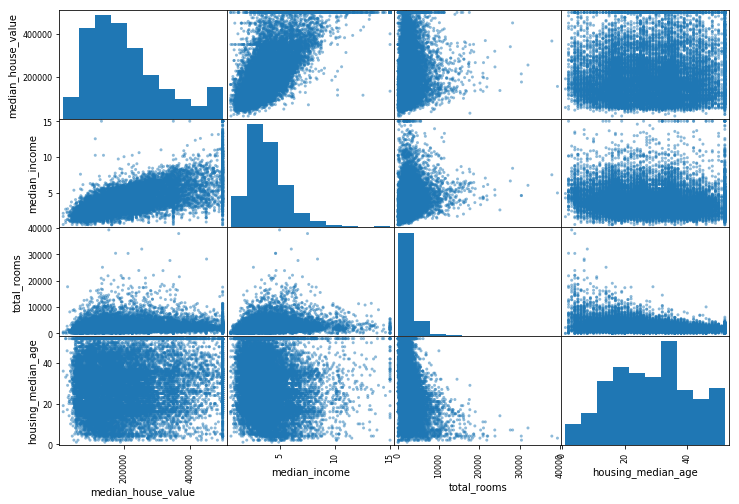

In [19]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

the most promising is median income so lets zoom in on that

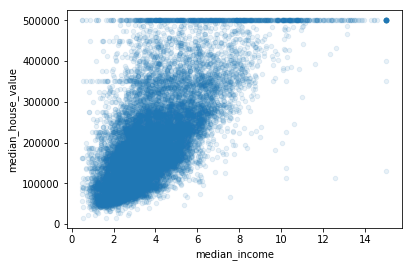

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## Prepare for Machine Learning Algorithms
Revert to the clean training set(by copying strat_train_set again), and separate the predictors and labels, since we dont necessariliy want to apply the same transformations to the predictors and the target values.  The drop creates a copy and does not affect start_train_set

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning ###
some rows are missing some features, like total_bedrooms. lets remove those rows using SciKit-Learn's **Imputer**.  Imputer is an **estimator**.  The estimation is performed by fit() method


In [22]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

median can only be computed on numberical values, so drop the text attributes

In [23]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [24]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [25]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

imputer has simply computed median of each attribute.  we know only total_bedrooms was missing values, but when live cant be so sure.  safer to apply imputer to all numerical values.  

Now you can use this "trained" imputer to transform the training set by replacing missing values by learned medians

In [26]:
X = imputer.transform(housing_num)

the result is a Numpy array containing transformed features.

### Handing Text ###
Earlier we left out ocean proximity since we cant computer median on text.  Most ML algos prefer numerical calues, so lets change this text field to numbers.  

Scikit Learn provides a transformer for this task called *LabelEncoder*.


In [27]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [28]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


This is great but the issue with this that ML algos will think that nearby values are more similar than two distanct values.  Thias is obviously not the case here.  To fix, a common solution is to create a binary attribute per category.  This is called **one-hot encoding**.

Scikit provider *OneHotEncoder* to convert interger categorical values into one-hot vectors. fit_transform() expects a 2D array, but housing_cat is a 1D array, so we need to reshape it.

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice the outpout is a sparse matrix instead of a NumPy array.  This is useful if we have lots of categories.  The matroix is full of 0s expect one 1 per row. Memory to store zeros would be very wasteful, so sprase matrix only stores locations of the nonzeros. But if you want to convert to NumPy array, call toarray().

In [30]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

We can apply both transformations (from text category to integer categories, then to one-hot vectors) in one shot using **LabelBinarizer**

In [31]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

this returns a dense NumPy array by default. pass *sparse_output=True* to the constructor if you want that.

### Custom Transformers ###
you want your transformers to work with scikit learn functionalities. You need to create a class with three methods. fit(), transform(), and fit_transform().  if you add TransformerMixin as base class, you get fit_transform() for free.  If you add BaseEstimator, you will get get_params() and set_params() for free.  Here is one that combines 2 attributes.

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room ]
        else:
            return np.c_[X, rooms_per_household, population_per_household ]


In [33]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling ###
is one of the most important transformations.  With a few exceptions, ML algos dont perform well when the input numerical attributes have very different scales.  In this case, total number of rooms range from about 6 to 39,320, while the median incomes only range from 0 to 15. 

Two common wats to get all attributes on the same scale is *min-max scaling* (normalization) and *standardization*.

Normalization ias simple, values are shifted and rescaledd so they end up ranging from 0 to 1.  This is done by subtracting the min value and dividing by the max minus the min.  SKL provides the transformer **MinMaxScaler**.  It has a feature range parameter if you dont want 0-1 for some reason.

Standardization is quite differet. First is subtracts the mean value, then divides by the variance so the resulting distribution has unit variance.  Unlike min-max, standardization does not bound values to a specific range, which may be a problem for more algos.  However standardization is much less affected by outliers.  SKL provides the transformer **StandardScaler**.



### Transformation Pipelines ###

SKL provides the *Pipeline* class to help with sequencing transformations.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

You now have a pipeline for numerical valies, and you also need to apply the LabelBinarizer.  SKL provides a *FeatureUnion* class for this. The full pipeline would look like this.

In [35]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [37]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])
    
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

DataFrameSelector is a simple transformer for SKL to handle Pandas DataFrames.

In [38]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### Select and Train a Model ###

#### Training and Evaluating on the Traingin Set ####

Let's try Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Done! You now have a working Linear Regression Model.  Let's try a few instances from the training set

In [40]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [41]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although not exactly accurate.  Lets measure this regression model's RMSE

In [42]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

Better than nothing, but a typcal prediction error of $68,000 is not very satisfying.  Let's try a more powerful model.

In [43]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

Perfect Model! Nah. more likely the model has badly overfit the data. 

#### Better Evaluation using Cross-Validation ####

use SKL's cross-validation feature.  its randomly splits the training set into N folds, then it trains and evaulates the decision tree model 10 times. The result is an array containing 10 evulation scores.

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [45]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [ 70074.60785921  67538.36328742  71776.3516293   69137.4001876
  70248.61911286  75890.02033598  72128.39168301  71436.97914938
  76339.53524771  70388.90021657]
Mean: 71495.9168709
Standard deviation: 2632.05459911


Doesnt look so good. Worse than linear regression.  It has an average error of 71000 and a +/- of 2756.  
Let's try on last model.

In [46]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

Much better.  

In [47]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard deviation: 2301.87380392


Notice the score on the training set is still much lower than on the validation sets meaning the model is still overfitting the training set.  Possible solutions is to simplify the model, or get more training data, or try another model.


### Fine Tune Your Model ###

You can manually fiddle with hyperparamters, but that would be tedious.  Instead you should use SKL GridSearchCV to search for you.  Tell it what parameters to experiment with and what values to try out, and it will evaluate all possible combinations using cross validation.  This code searches for the best combo of hyperparameters values for the RandomForestRegressor.

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [50]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


Let's look at the score of each hyperparameter combination tested during the grid search:

In [51]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.854446 {'max_features': 2, 'n_estimators': 3}
55611.5015988 {'max_features': 2, 'n_estimators': 10}
53370.0640736 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.4998083 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.8922859 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.3582936 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.0168279 {'bootstrap': False, 'max_features': 4, 'n_estima

RMSE of 49694 which is slighty better than the previous scores.


### Randomized Search ###

grid search is fine for a few params, but if there are lots then you should use RandomizedSearchCV.

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)


cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50797.0573732 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50775.4633168 {'max_features': 3, 'n_estimators': 75}
50681.383925 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50473.0175142 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


### Analyze the Best Models and Their Errors ###

Gain insight by inspecting the best model. Like which feartures are most important

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [54]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813418, 'median_income'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.073344235516012421, 'longitude'),
 (0.062909070482620302, 'latitude'),
 (0.056419179181954007, 'rooms_per_hhold'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

You may want to drop the less useful features like a few of the ocean proximity features.

### Evaulate your system on the Test Set ###

Now its time to evaulate the final model on the test set. run your fill pipeline to transform the data. NOT fit_transform, and evaulate the final model on the test set

In [55]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [56]:
final_rmse

47766.003966433083